In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd 
import numpy as np
import time
import glob
import os

# Interpolater used for Radial-Basis-function inerpolation of implied volatility surface
from scipy import interpolate
from scipy.interpolate import RBFInterpolator
from scipy.optimize import differential_evolution # Used in calibrating Heston SV-model

# Allows for plotting 3D surfaces
from mpl_toolkits.mplot3d import Axes3D

# For clean outputs of cells
import warnings
warnings.filterwarnings('ignore')

saveFigures = True

# Data import

In [2]:
# Path to folder where data is stored in flat files
dataFolder = "/Users/sebastianbech/Desktop/Seminar - Asset prices and financial markets/Code/Data"

## Load option chains data

In [3]:
# List of all option chains files
OC_dataFiles = glob.glob(os.path.join(dataFolder + '/option chains', "*.txt")) 

# Columns to be used
columns = {' [QUOTE_DATE]'      : 'Date',
           ' [UNDERLYING_LAST]' : 'underlyingLast', 
           ' [DTE]'             : 'DTE',            # Days till Expiry
           ' [C_IV]'            : 'c_sigma',
           ' [C_LAST]'          : 'c_last',
           ' [STRIKE]'          : 'strike'
}

# Read all datafiles into separate dataframes
OC_dataFiles_df = (pd.read_csv(file, 
                               low_memory=False,
                               delimiter = ',',
                               usecols = columns.keys(),
                               parse_dates = [' [QUOTE_DATE]'],
                               date_format='%Y-%m-%d'
                              ) for file in OC_dataFiles)

# Concat dataframes for all data files into one dataframe
option_df   = (pd.concat(OC_dataFiles_df, ignore_index=True)
               .rename(columns = columns)
               .map(lambda x: x.strip() if isinstance(x, str) else x)  # Remove all whitespace from string columns
               .apply(lambda col: pd.to_numeric(col, downcast='float', errors='ignore')) # Convert cols to optimal numeric datatype if possible                   
               .query('not (c_last == 0 and underlyingLast > strike)') # Excluding obs where no price is observed for in-the-money options
               .dropna()
               .astype({'Date':'str', 'DTE' : 'int32'})
               .set_index(['Date','strike'])
               .sort_index()
              )

print(f'Dataframe has {option_df.shape[0]:,} rows and {option_df.shape[1]} columns')


Dataframe has 3,727,627 rows and 4 columns


## Load yield curve data

In [4]:
# List of all flat files containing yield curve data
yc_dataFiles = glob.glob(os.path.join(dataFolder + '/US yield curves', "*.csv")) 

# Read all datafiles into separate dataframes
yc_dataFiles_df = (pd.read_csv(file, 
                               low_memory=False, 
                               delimiter = ',',
                               parse_dates = ['Date'], 
                               date_format='%m/%d/%Y'
                              ) for file in yc_dataFiles)

# Concat dataframes for all data files into one dataframe
yield_curves = (pd.concat(yc_dataFiles_df, ignore_index=True)
                .astype({'Date':'str'})
                .set_index('Date')
                .astype('float32', errors='ignore') # Downscale from float64 to float32 to improve memory usage - can be reduced to float16 but this dtype can not represent two digits precisely hence it is a tradeoff between precision and computational efficiency
                .interpolate(axis=1) # Linearly interpolate missing curve points
                .sort_index()
                
              )

print(f'Dataframe has {yield_curves.shape[0]:,} rows and {yield_curves.shape[1]} columns')


Dataframe has 1,100 rows and 13 columns


## Join option chain and yield curve data

In [5]:
# Used for translating source names into names used in ML models
translation = {
    'underlyingLast'  : 'S',
    'strike'          : 'K',
    'DTE'             : 'T',
    'c_sigma'         : 'sigma',
    'c_last'          : 'observed_price'
}

# Join rates onto option chain data
mkt_data = (option_df.merge(yield_curves, how='left', left_index=True, right_index=True, validate='many_to_one')
            .reset_index()
            #.drop('Date',axis=1)
            .astype({'Date':'datetime64[ns]'})
            .rename(columns=translation)
            .dropna()
            .assign(moneyness=lambda x: x["S"]-x["K"])
            # Sort on date and strike
            )

# Rename yield curve columns to comply with Quantlib period format
mkt_data.rename(columns={'1 Mo':'1m', 
                         '2 Mo':'2m', 
                         '3 Mo':'3m', 
                         '4 Mo':'4m', 
                         '6 Mo':'6m',
                         '1 Yr':'1y',
                         '2 Yr':'2y',
                         '3 Yr':'3y',
                         '5 Yr':'5y',
                         '7 Yr':'7y',
                         '10 Yr':'10y',
                         '20 Yr':'20y',
                         '30 Yr':'30y'},
                inplace=True)

# print shape of dataframe
print(f'Dataframe has {mkt_data.shape[0]:,} rows and {mkt_data.shape[1]} columns')

Dataframe has 3,669,293 rows and 20 columns


## Descriptive analysis of data

Figure saved as figures/parYieldTS.png


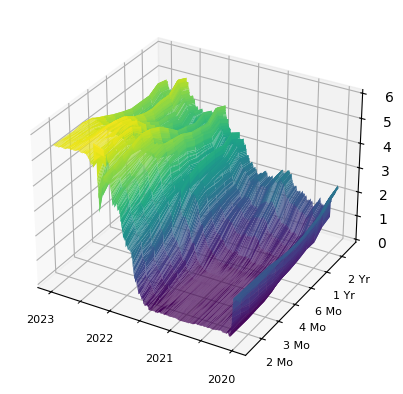

In [84]:
# 3d yield graph

xv, yv = np.meshgrid(np.arange(1,len(yield_curves.index) + 1,1), np.arange(1,len(yield_curves.columns) + 1))

# Create figure 
fig, ax = plt.subplots(1,1,figsize=plt.figaspect(0.5), subplot_kw=dict(projection='3d'))
#fig.set_tight_layout(True)

surf = ax.plot_surface(xv, yv, yield_curves.values.T, rstride=1, cstride=1, linewidth=0.1, cmap='viridis')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_ticklabels([0,2020,2021,2022,2023],fontsize=8)
ax.invert_xaxis()

ax.yaxis.set_ticklabels(yield_curves.columns, fontsize=8)

ax.zaxis.label.set_size(fontsize=8)


plt.tight_layout()

if saveFigures:
    fileName = 'figures/parYieldTS.png'
    fig.savefig(fileName, dpi=300, bbox_inches="tight")
    print(f'Figure saved as {fileName}')

plt.show()

Figure saved as figures/priceSPY.png


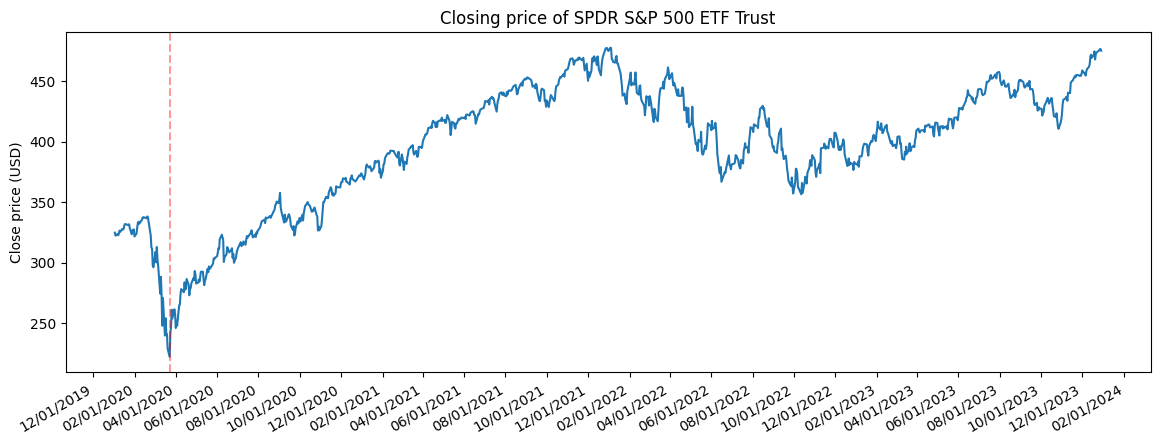

In [56]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(1,1,figsize=(14,5))

maxPrice = max(mkt_data['S'])
minPrice = min(mkt_data['S'])

ax.plot(mkt_data['Date'],mkt_data['S'],color='tab:blue')
#ax.vlines('2020-03-23', minPrice, maxPrice)
ax.axvline(pd.Timestamp('2020-03-23'),alpha=0.4, color='r', linestyle='dashed')
#ax.xaxis.set_ticklabels()
ax.set_ylabel('Close price (USD)')
ax.set_title("Closing price of SPDR S&P 500 ETF Trust")
#ax.xaxis.set_tick_params(rotation=30, labelsize=10)
#plt.xlim(minDate,maxDate)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gcf().autofmt_xdate()

if saveFigures:
    fileName = 'figures/priceSPY.png'
    fig.savefig(fileName, dpi=300, bbox_inches="tight")
    print(f'Figure saved as {fileName}')

plt.show()

# World state setup

In [8]:
# Pick observation to be used for market data setup and evaluation
obs = mkt_data.iloc[188288,:] # Observation for date with most data - 2020-03-23
#obs = mkt_data.iloc[1,:] #  more normal IV surface

# Set day of pricing as day of observation
valuation_date = ql.Date(str(obs['Date'].date()),'%Y-%m-%d')

# Set evaluation date for Quantlib instance
ql.Settings.instance().evaluationDate = valuation_date

# Define calendar
#calendar = ql.NullCalendar()
calendar = ql.UnitedStates(ql.UnitedStates.FederalReserve)

# Set day count scheme
dayCounter = ql.Actual365Fixed()

In [9]:
# Retrieve yield curve data from chosen observation
obs_curve = obs['1m' : '30y']

# Initiate list for input to yield curve starting from valuation date
yc_dates = [valuation_date]

# Extract and divide yields with 100 to get a list of yields as decimals
rates = list(obs_curve.astype(float) / 100)

# Insert 1M point as proxy for OIS (Rate corresponding to valuation day)
rates.insert(0,rates[0])

# Append yield curve dates list with maturity date for each tenor
for point in obs_curve.index:
    yc_dates.append(valuation_date + ql.Period(point))

# Create risk free yield curve 
zc = ql.ZeroCurve(yc_dates, rates, dayCounter, calendar)

# Create risk free interest rate term structure handle. Handles allow for changing curve without recalibrating
riskFreeTS = ql.YieldTermStructureHandle(zc)

# Dividend curve for underlying, assumed to be constant 1%
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(valuation_date, 0.01, dayCounter))

# Initial value of underlying
underlying = ql.SimpleQuote(float(obs['S']))
initialValue = ql.QuoteHandle(underlying)

## Sample selection

In [10]:
# Select all option chain data for current evaluation date
smpl = mkt_data[mkt_data['Date'] == obs['Date']]

# Select days till maturity, strike and implied vol of calls and pivot to create grid of implied volatilities
iv_smpl = smpl[['T','K','sigma']].pivot(columns='T', index='K', values='sigma') #/ 100

# Implied volatility interpolation and smoothing

In [11]:
# Count number og observations per tenor
cnts = iv_smpl.nunique(axis=1)

# Find the median of observations per tenor
cutoff = cnts.quantile(q=0.50)

# Exclude all tenors with observation counts below the median and extract 
cnts_idx = cnts[cnts > cutoff].index

#
preSmoothingData = iv_smpl[iv_smpl.index.isin(cnts_idx)].interpolate(axis=1).dropna(axis=1)

#
smoothingStrikes = preSmoothingData.index
smoothingTenors = preSmoothingData.columns

# Create grid of coordinates times 2 :i
grid_strikes, grid_tenors = np.meshgrid(smoothingStrikes, smoothingTenors, indexing='ij')
#xv, yv = np.meshgrid(smoothingStrikes, smoothingTenors, indexing='ij')

preSmoothingVols = preSmoothingData.values


# Flatten the coordinate arrays and DataFrame values
coords = np.column_stack([grid_strikes.ravel(), grid_tenors.ravel()])
values = preSmoothingVols.ravel()

Figure saved as figures/nonSmoothedVolSurf.png


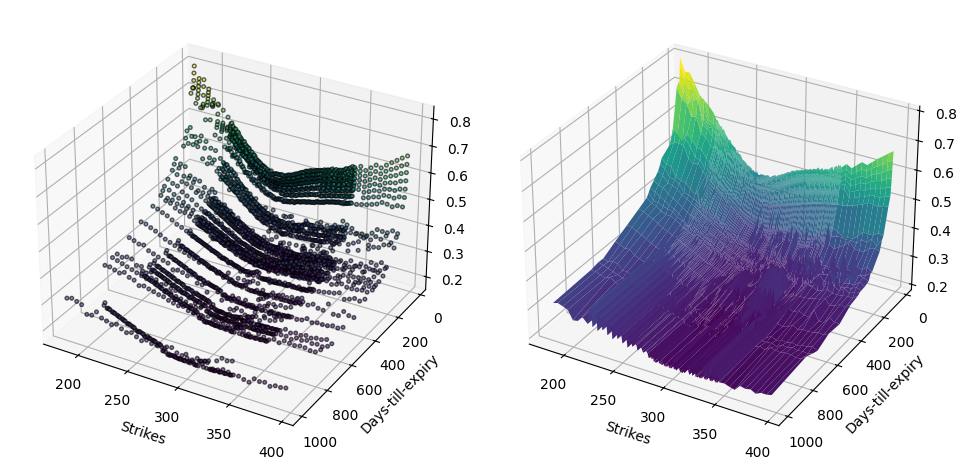

In [12]:

# Create figure 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=plt.figaspect(0.5), subplot_kw=dict(projection='3d'))
fig.set_tight_layout(True)

scatter = ax1.scatter(coords[:, 0], coords[:, 1],values, c=values, cmap='viridis', s=7, edgecolor='k', alpha=0.6)
ax1.set_xlabel('Strikes')
ax1.set_ylabel('Days-till-expiry')
#ax1.set_zlabel('Implied volatility')
ax1.invert_yaxis()



# Plot non smoothed observations as surface
#ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(grid_strikes, grid_tenors, preSmoothingVols, rstride=1, cstride=1, linewidth=0.1, cmap='viridis')
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Days-till-expiry')
#ax2.set_zlabel('Implied volatility')
ax2.invert_yaxis()

plt.tight_layout(w_pad=3)

if saveFigures:
    fileName = 'figures/nonSmoothedVolSurf.png'
    fig.savefig(fileName, dpi=300, bbox_inches="tight")
    print(f'Figure saved as {fileName}')

plt.show()

## Polynomial smoothing
In this section i fit a second degree polynomial on the iv across strikes for each tenor

Figure saved as figures/polySmoothed.png


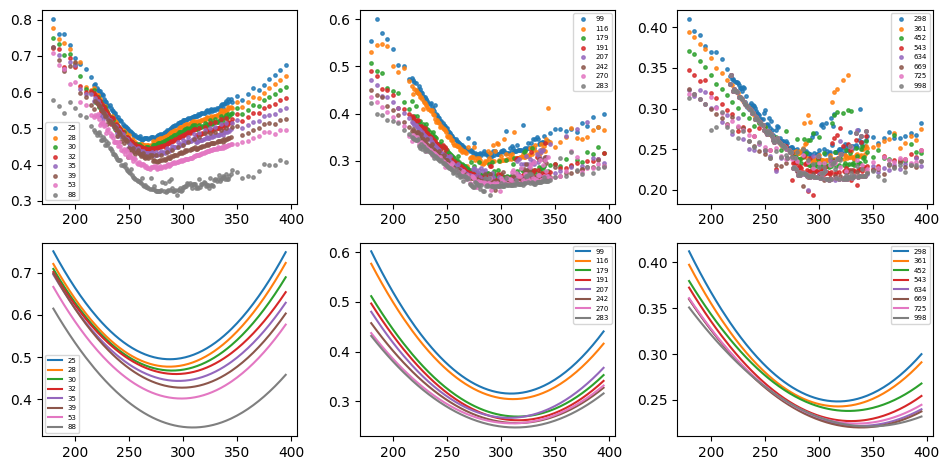

In [13]:
# Start index for slices of tenors
idx_start = [0,8,16]

# End index for slicee of tenorss
idx_end = [8,16,len(preSmoothingData.columns)]

# Initiate datafram to hold fitted data 
polyVolDf = pd.DataFrame(index=preSmoothingData.index)

fig, axes = plt.subplots(2,3,figsize=plt.figaspect(0.5))
fig.set_tight_layout(True)

figCol = 0

# For each slice of tenors
for i, j in zip(idx_start, idx_end):
    
    
    # For each tenor i slice
    for t in preSmoothingData.columns[i : j]:
        x1 = preSmoothingData.index
        y1 = preSmoothingData[t]

        # Plot data points
        axes[0,figCol].scatter(x= x1, y=y1,label=t, alpha=0.8, s=6)
        axes[0,figCol].legend(fontsize=5)
        
        # Remove N/A obervations in prep for fit
        y2 = y1.dropna()
        
        # Fit 2-degree polynomial
        model = np.poly1d(np.polyfit(y2.index, y2, 2))

        # Evaluate fitted polynomial for grid of strikes
        y2 = model(x1)

        polyVolDf[t] = y2
        
        # Plot fitted lines
        #plt.subplot(1, 2, 2)
        axes[1,figCol].plot(x1, y2,label=t)
        axes[1,figCol].legend(fontsize=5)
    
    
    figCol += 1

polySmoothedVol = polyVolDf.values

if saveFigures:
    fileName = 'figures/polySmoothed.png'
    fig.savefig(fileName, dpi=300, bbox_inches="tight")
    print(f'Figure saved as {fileName}')

plt.show()

## Bi-cubic spline smoothing on iv surface
See:
- https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.bisplrep.html#scipy.interpolate.bisplrep

In [14]:
tck = interpolate.bisplrep(grid_strikes, grid_tenors, preSmoothingVols, s=0.5, kx=2,ky=2)

splSmoothedVol = interpolate.bisplev(smoothingStrikes, smoothingTenors, tck)

splVolDf = pd.DataFrame(index=smoothingStrikes , columns=smoothingTenors, data=splSmoothedVol)

## Radial Basis function smoothing on iv curve
See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html#scipy.interpolate.RBFInterpolator

In [15]:
# Flatten the coordinate arrays and DataFrame values
coords = np.column_stack([grid_strikes.ravel(), grid_tenors.ravel()])
values = preSmoothingVols.ravel()

# Interpolate current strike x tenor grid with radial basis functions
interpolator = RBFInterpolator(coords, values, smoothing=20000)

# Evaluate the RBFinterpolator on the original grid - could be done on a finer or extended grid
rbfSmoothedVol = interpolator(coords).reshape(preSmoothingData.shape)

# Create dataframe from RBF smoothed vol data
rbfVolDf = pd.DataFrame(index=smoothingStrikes , columns=smoothingTenors, data=rbfSmoothedVol)

## Evaluation of smoothing

### Smoothed volatility surfaces 3D-plots

Figure saved as figures/SmoothedVolSurfs.png


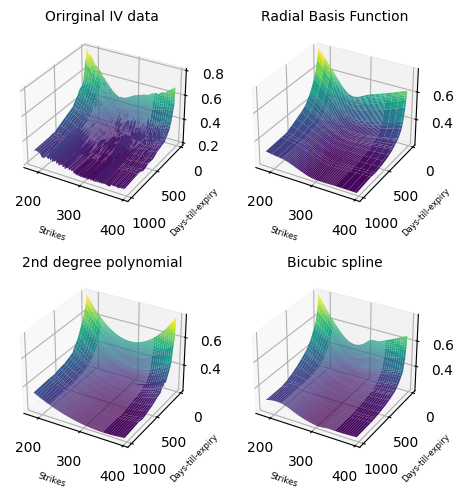

In [16]:
# Create figure 
fig, axes = plt.subplots(2,2,figsize=plt.figaspect(1), subplot_kw=dict(projection='3d'))
fig.set_tight_layout(True)

# Original non-smoothed IV
surf = axes[0,0].plot_surface(grid_strikes, grid_tenors, preSmoothingVols, rstride=1, cstride=1, linewidth=0.1, cmap='viridis')
axes[0,0].set_xlabel('Strikes', fontsize= 6)
axes[0,0].set_ylabel('Days-till-expiry', fontsize= 6)
axes[0,0].invert_yaxis()
axes[0,0].set_title('Orirginal IV data', fontsize=10)

# RBF smoothed IV
surf = axes[0,1].plot_surface(grid_strikes, grid_tenors, rbfSmoothedVol, cmap='viridis', edgecolor='none')
axes[0,1].set_xlabel('Strikes', fontsize= 6)
axes[0,1].set_ylabel('Days-till-expiry', fontsize= 6)
axes[0,1].invert_yaxis()
axes[0,1].set_title('Radial Basis Function', fontsize=10)
#fig.colorbar(surf, ax=axes[0,1], shrink=0.5, aspect=5)

# Polynomial smoothed IV
surf = axes[1,0].plot_surface(grid_strikes, grid_tenors, polySmoothedVol, rstride=1, cstride=1, linewidth=0.1, cmap='viridis')
axes[1,0].set_xlabel('Strikes', fontsize= 6)
axes[1,0].set_ylabel('Days-till-expiry', fontsize= 6)
axes[1,0].invert_yaxis()
axes[1,0].set_title('2nd degree polynomial', fontsize=10)
#fig.colorbar(surf, ax=axes[1,0], shrink=0.5, aspect=5)

# Bi-cubic spline smoothed IV
surf = axes[1,1].plot_surface(grid_strikes, grid_tenors ,splSmoothedVol, rstride=1, cstride=1, linewidth=0.1, cmap='viridis')
axes[1,1].set_xlabel('Strikes', fontsize= 6)
axes[1,1].set_ylabel('Days-till-expiry', fontsize= 6)
axes[1,1].invert_yaxis()
axes[1,1].set_title('Bicubic spline', fontsize=10)
#fig.colorbar(surf, ax=axes[1,1], shrink=0.5, aspect=5)

plt.tight_layout(h_pad=3)

if saveFigures:
    fileName = 'figures/SmoothedVolSurfs.png'
    fig.savefig(fileName, dpi=400, bbox_inches="tight")
    print(f'Figure saved as {fileName}')
    

plt.show()

### Smoothed volatility surfaces colormesh plots

Figure saved as figures/colormeshSmoothed.png


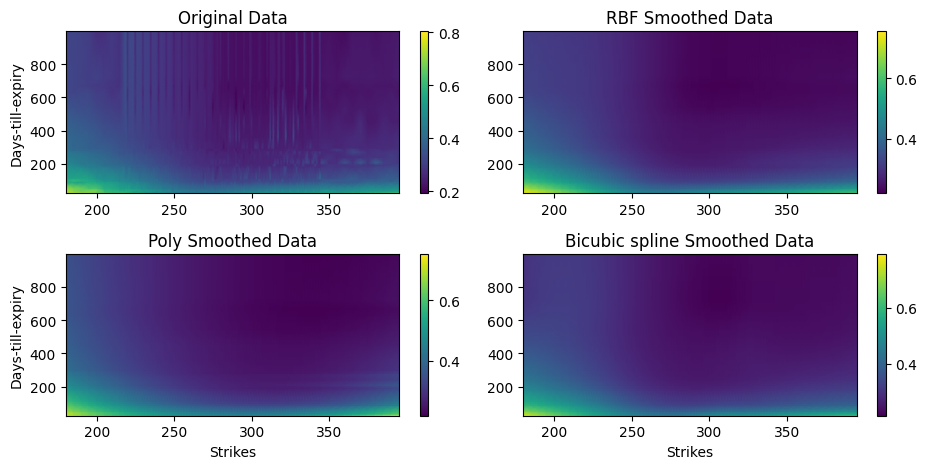

In [17]:
# Create the plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=plt.figaspect(0.5))

# Plot original data
original_plot = ax1.pcolormesh(grid_strikes, grid_tenors, preSmoothingVols, shading='gouraud')
ax1.set_title('Original Data')
#ax1.set_xlabel('Strikes')
ax1.set_ylabel('Days-till-expiry')
fig.colorbar(original_plot, ax=ax1)

# Plot RBF smoothed data
RBF_smoothed_plot = ax2.pcolormesh(grid_strikes, grid_tenors, rbfSmoothedVol, shading='gouraud')
ax2.set_title('RBF Smoothed Data')
#ax2.set_xlabel('Strikes')
#ax2.set_ylabel('Days-till-expiry')
fig.colorbar(RBF_smoothed_plot, ax=ax2)

# Plot polynomial smoothed data
poly_smoothed_plot = ax3.pcolormesh(grid_strikes, grid_tenors, polySmoothedVol, shading='gouraud')
ax3.set_title('Poly Smoothed Data')
ax3.set_xlabel('Strikes')
ax3.set_ylabel('Days-till-expiry')
fig.colorbar(poly_smoothed_plot, ax=ax3)

# Plot another smoothed data
bispl_smoothed_plot = ax4.pcolormesh(grid_strikes, grid_tenors, splSmoothedVol, shading='gouraud')
ax4.set_title('Bicubic spline Smoothed Data')
ax4.set_xlabel('Strikes')
#ax4.set_ylabel('Days-till-expiry')
fig.colorbar(bispl_smoothed_plot, ax=ax4)

plt.tight_layout()

if saveFigures:
    fileName = 'figures/colormeshSmoothed.png'
    fig.savefig(fileName, dpi=400, bbox_inches="tight")
    print(f'Figure saved as {fileName}')
    
plt.show()

# Local volatility surface
In this section i create and calibrate local volatility surfaces from two methods. Finally i evaluate which is better and continue the ananlysis with this one

## Create and calibrate local volatility surface
Here i choose IV data to be used as well as compute Black variance surface

In [18]:
# Set which smoothed surface to use for rest of the calibration
volData = rbfVolDf # Radial Basis function smoothed vol surface
#volData = polyVolDf # 2nd degreee polynomial smoothed vol surface
#volData = splVolDf # Bi-cubic spline smoothed vol surface

# Set expiration dates for volatility grid as valuation date plus days-till-expiry in separate vector
expirationDates = [valuation_date + ql.Period(days, ql.Days) for days in list(volData.columns)]

# Extract strikes included in volatility surface in seperate vector
strikes = list(volData.index)

# Extract implied vol data into matrix with dimensions: strike x maturity
data = volData.values.tolist()

# Convert implied-volatility matrix to Quantlib format
impliedVols = ql.Matrix(data)

# Create Black-Scholes variance surface
BlackVarSurface = ql.BlackVarianceSurface(valuation_date, calendar, expirationDates, strikes, impliedVols, dayCounter)
BlackVarSurface.enableExtrapolation()

# Black-Scholes term structure handle
BlackVarHandle = ql.BlackVolTermStructureHandle(BlackVarSurface)

### Dupire local volatility

In [19]:
# Set parameter for override parameter for exception ignoring implementation of local vol- set to 0 for safe model
illegalVolOverride = 0.001

if illegalVolOverride:
    print("No exceptions model chosen")
    
    # Dupire local volatility implementation that ignores exceptions
    localVol = ql.NoExceptLocalVolSurface(BlackVarHandle, riskFreeTS, dividendTS, initialValue, illegalVolOverride)
    localVol.enableExtrapolation()
    
else:
    print("Safe model chosen")
    
    # Dupire local vol surface  - fails because of extreme edge cases and calendar arbitrage
    localVol = ql.LocalVolSurface(BlackVarHandle, riskFreeTS, dividendTS, initialValue)
    localVol.enableExtrapolation()
    

No exceptions model chosen


### Andreasen and Huge local volatility implementation
See: 
- https://hpcquantlib.wordpress.com/2018/01/05/andreasen-huge-volatility-interpolation/
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1694972


In [20]:
calibrationSet = ql.CalibrationSet()

for strike, expiry, impliedVol in zip(strikes, list(volData.columns), volData.values.ravel().tolist()):
  payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)
  exercise = ql.EuropeanExercise(calendar.advance(valuation_date, ql.Period(expiry, ql.Days)))

  calibrationSet.push_back((ql.VanillaOption(payoff, exercise), ql.SimpleQuote(impliedVol)))

ahInterpolation = ql.AndreasenHugeVolatilityInterpl(calibrationSet, initialValue, riskFreeTS, dividendTS)
ahLocalSurface = ql.AndreasenHugeLocalVolAdapter(ahInterpolation)
ahLocalSurface.enableExtrapolation()

## Evaluate local volatility surfaces

In [86]:
# Create function to plot vol surfaces from Quantliv containers
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, 3, 0.1), 
                     plot_strikes=np.arange(70, 130, 1), funct='blackVol', 
                     invertY = True, saveFig = False, fileName = None, colorBar = True):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.1, cmap='viridis')
    if invertY:
        ax.invert_yaxis()
    
    if colorBar:
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    if saveFig:
        fig.savefig(fileName, dpi=400, bbox_inches="tight")
        print(f'Figure saved as {fileName}')
        
    plt.show()    

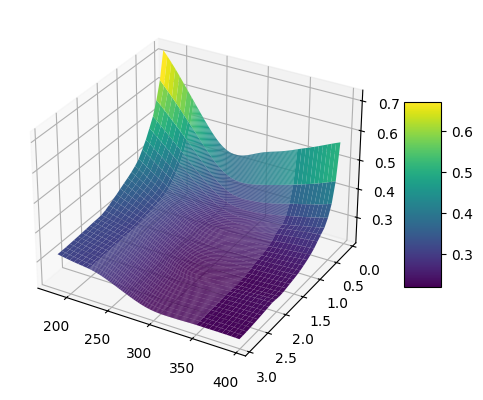

In [87]:
plot_vol_surface(BlackVarSurface, plot_strikes=strikes,funct='blackVol')

Figure saved as figures/localVol.png


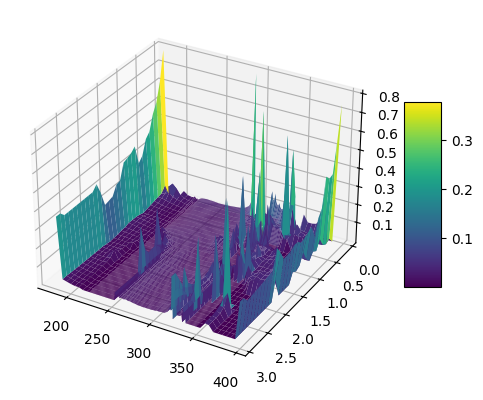

In [88]:
plot_vol_surface(localVol, plot_strikes=strikes,funct='localVol', saveFig = True, fileName = 'figures/localVol.png')

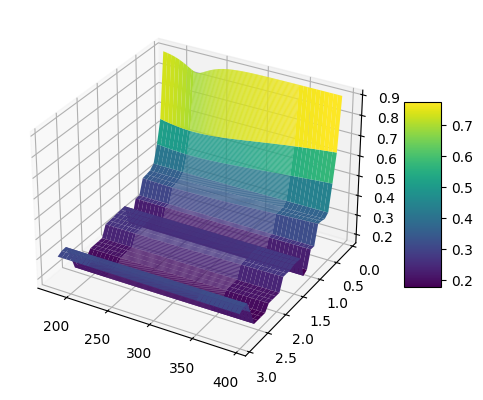

In [24]:
plot_vol_surface(ahLocalSurface, plot_strikes=strikes, funct='localVol')

# Heston SLV model 

## Calibration of Heston SV-model

In [25]:
def setup_helpers(engine, expiration_dates, strikes, data, ref_date, spot, yield_ts, dividend_ts):
    heston_helpers = []
    grid_data = []
    for i, date in enumerate(expiration_dates):
        for j, s in enumerate(strikes): 
            t = (date - ref_date )
            p = ql.Period(t, ql.Days) 
            vols = data[j][i]
            helper = ql.HestonModelHelper(p, calendar, spot, s, ql.QuoteHandle(ql.SimpleQuote(vols)), yield_ts, dividend_ts)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def cost_function_generator(model, helpers,norm=False): 
    def cost_function(params):
        params_ = ql.Array(list(params)) 
        model.setParams(params_)
        error = [h.calibrationError() for h in helpers] 
        if norm:
            return np.sqrt(np.sum(np.abs(error))) 
        else:
            return error 
    return cost_function


def calibration_report(helpers, grid_data, detailed=False): 
    avg = 0.0
    if detailed:
        print("%15s %25s %15s %15s %20s" % ("Strikes", "Expiry", "Market Value", "Model Value", "Relative Error (%)"))
        print("="*100)
        
    for i, opt in enumerate(helpers):
        err = (opt.modelValue()/opt.marketValue() - 1.0) 
        date,strike = grid_data[i]
        if detailed:
            print("%15.2f %25s %14.5f %15.5f %20.7f " % (strike, str(date), 
                                                         opt.marketValue(), 
                                                         opt.modelValue(), 
                                                         100.0*(opt.modelValue()/opt.marketValue() - 1.0)))
        
        avg += abs(err)
        
    avg = avg*100.0/len(helpers)
    
    if detailed: print("-"*100)
    summary = "Average Abs Error (%%) : %5.9f" % (avg) 
    print(summary)
    return avg

def setup_model(_yield_ts, _dividend_ts, _spot, init_condition=(0.02,0.2,0.5,0.1,0.01)):
    theta, kappa, sigma, rho, v0 = init_condition
    process = ql.HestonProcess(_yield_ts, _dividend_ts,
                                      ql.QuoteHandle(ql.SimpleQuote(_spot)),
                                      v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    return model, engine 



In [99]:
summary= []

spot = float(obs['S'])

model4, engine4 = setup_model(riskFreeTS, dividendTS, spot)

heston_helpers4, grid_data4 = setup_helpers(engine4, expirationDates, strikes, data,
                                            valuation_date, spot, riskFreeTS, dividendTS)

initial_condition = list(model4.params())
#bounds = [(0,1),(0.01,15), (0.01,1.), (-1,1), (0,1.0) ]
bounds = [(0,1),(0.01,15), (0.01,10.), (-1,1), (0,1.0) ]

cost_function = cost_function_generator(model4, heston_helpers4, norm=True)

sol = differential_evolution(cost_function, bounds)#, maxiter=1000)

theta, kappa, sigma, rho, v0 = model4.params()

print("theta = %.4f, kappa = %.4f, sigma = %.4f, rho = %.4f, v0 = %.4f" % (theta, kappa, sigma, rho, v0))

error = calibration_report(heston_helpers4, grid_data4)
summary.append(["SciPy DE1", error] + list(model4.params()))

theta = 0.1488, kappa = 5.3808, sigma = 6.2781, rho = -0.7288, v0 = 0.7505
Average Abs Error (%) : 8.680830085


In [100]:
paramEst = pd.DataFrame(summary, 
             columns=["Name", "Avg Abs Error","Theta", "Kappa", "Sigma", "Rho", "V0"], 
             index=['']*len(summary))

paramEst

,Name,Avg Abs Error,Theta,Kappa,Sigma,Rho,V0
,SciPy DE1,8.68083,0.148844,5.380765,6.278057,-0.728846,0.750509


## Final parameterization of the Heston SV-model

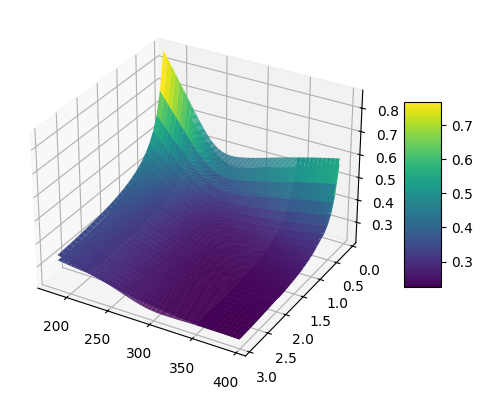

In [103]:
# Parameters
"""
v0 = 0.006 # Original value: 0.005 - Initial variance
kappa = 0.6    # Original value: 0.8 - Mean reversion rate: The speed at which the volatility reverts to its long-term average
theta = 0.005  # Original value: 0.008 - The long-term average volatility level to which the volatility reverts
rho = -0.4     # Original value: 0.2 - Correlation between asset price and volatility
sigma = 0.12    # Original value: 0.1 - volatility of volatility
"""
v0    = float(paramEst['V0'])
kappa = float(paramEst['Kappa'])
theta = float(paramEst['Theta'])
rho   = float(paramEst['Rho'])
sigma = float(paramEst['Sigma'])

# Define heston process
hestonProcess = ql.HestonProcess(riskFreeTS, dividendTS, initialValue, v0, kappa, theta, sigma, rho)

# How does the vol surface look at the moment?
hestonModel = ql.HestonModel(hestonProcess)


heston_handle = ql.HestonModelHandle(hestonModel)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Plot the vol surface ...
plot_vol_surface([BlackVarSurface, heston_vol_surface], plot_strikes=strikes)
#plot_vol_surface([heston_vol_surface], plot_strikes=strikes, invertY=True)

## Calibration of leverage function (mixing parameter)

In [116]:
# Calibrate Leverage Function to the Local Vol and Heston Model via Monte-Carlo
timeStepsPerYear = 365
nBins = 201
calibrationPaths = 2**16 # Increase to 2**19?
mandatoryDates = []
mixingFactor = 0.9

#localVol = ahLocalSurface
localVol = localVol

# Set maturity date for option as the valuation plus days till expiry
endDate = valuation_date + ql.Period(int(obs['T']),ql.Days)

#
generatorFactory = ql.MTBrownianGeneratorFactory()

# Calibrate SLV model with MC
stochLocalMcModel = ql.HestonSLVMCModel(localVol, hestonModel, generatorFactory, endDate, timeStepsPerYear, nBins, calibrationPaths, mandatoryDates, mixingFactor)

# Retrieve leverage function function from SLV model
leverageFct = stochLocalMcModel.leverageFunction()

#
tGrid, xGrid, vGrid = 1000, 100, 50
#tGrid, xGrid, vGrid = 10, 10, 5

#
dampingSteps = 0

# Finite differences scheme
fdScheme = ql.FdmSchemeDesc.ModifiedCraigSneyd()

# Set up pricing engine
engine = ql.FdHestonVanillaEngine(hestonModel, tGrid, xGrid, vGrid, dampingSteps, fdScheme, leverageFct, mixingFactor)


# Pricing evaluation

In [117]:
obs

Date              2020-03-23 00:00:00
K                                40.0
S                          222.210007
T                                  88
sigma                           4.842
observed_price             281.220001
1m                               0.01
2m                               0.04
3m                               0.02
4m                               0.05
6m                               0.08
1y                               0.17
2y                               0.28
3y                               0.31
5y                               0.38
7y                               0.63
10y                              0.76
20y                              1.12
30y                              1.33
moneyness                  182.210007
Name: 188288, dtype: object

In [118]:
strike = float(obs['K'])
maturity = valuation_date + ql.Period(int(obs['T']),ql.Days)
option_type = ql.Option.Call

In [119]:
payoff = ql.PlainVanillaPayoff(option_type, strike)
binaryPayoff = ql.CashOrNothingPayoff(option_type, strike, 1)

americanExercise = ql.AmericanExercise(valuation_date, maturity)
americanOption = ql.VanillaOption(payoff, americanExercise)

americanOption.setPricingEngine(engine)
americanOption.NPV()

182.2100063653061

In [ ]:
optionPrices.loc[50:110][1:30]

In [200]:
smplStrikes = smpl['K'].unique()[90:92]#[50:110]
smplDTEs = np.sort(smpl['T'].unique())[1:30]

optionPrices = pd.DataFrame(index=smplStrikes, columns=smplDTEs )

option_type = ql.Option.Call

for k in smplStrikes:
    strike = float(k)
    
    for t in smplDTEs:
        maturity = valuation_date + ql.Period(int(t),ql.Days)
        
        payoff = ql.PlainVanillaPayoff(option_type, strike)
        
        americanExercise = ql.AmericanExercise(valuation_date, maturity)
        americanOption = ql.VanillaOption(payoff, americanExercise)
        
        americanOption.setPricingEngine(engine)
        optionPrices.loc[k][t] = americanOption.NPV()

Text(0.5, 0.5, 'Days-till-expiry')

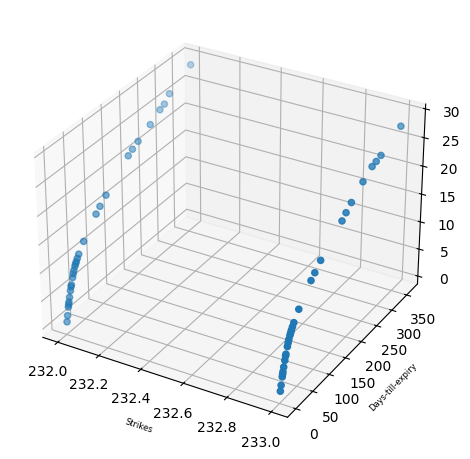

In [204]:
fig, ax = plt.subplots(1,1,figsize=plt.figaspect(1), subplot_kw=dict(projection='3d'))
fig.set_tight_layout(True)

xv, yv = np.meshgrid(smplStrikes, smplDTEs)

# 
surf = ax.scatter(xv, yv, optionPrices.values.T, cmap='viridis')
ax.set_xlabel('Strikes', fontsize= 6)
ax.set_ylabel('Days-till-expiry', fontsize= 6)
#ax.invert_yaxis()
#ax.set_title('', fontsize=10)